In [1]:
%%HTML
<script src="require.js"></script>

In [14]:
# Import necessary modules
import pandas as pd
import seaborn as sns

<img src='https://i.imgur.com/jzRQsuC.png' width = 600>

<div style="background-color: #ffd3a0; width: 200px; padding: 10px; border-radius: 5px; width: 98.8%">
    <h1 style="color: #5a3731; margin: 0;">Abstract</h1>
</div>

<div style="background-color: #ffd3a0; width: 200px; padding: 10px; border-radius: 5px; width: 98.8%">
    <h1 style="color: #5a3731; margin: 0;">Background</h1>
</div>

<div style="background-color: #fff3e4; width: 200px; padding: 10px; border-radius: 5px; width: 98.8%">
    <h2 style="color: #5a3731; margin: 0;">Problem Statement</h2>
</div>

The study aims to answer the main problem: **How can explicit user ratings be utilized to recommend board games based on similar users?**

To address the main question, the study will also uncover answers to the following subquestion:
- Which collaborative filtering methods, neighborhood- or model-based method, result in a better performance?


<div style="background-color: #fff3e4; width: 200px; padding: 10px; border-radius: 5px; width: 98.8%">
    <h2 style="color: #5a3731; margin: 0;">Motivation</h2>
</div>

<div style="background-color: #fff3e4; width: 200px; padding: 10px; border-radius: 5px; width: 98.8%">
    <h2 style="color: #5a3731; margin: 0;">Key Terms</h2>
</div>

<div style="background-color: #ffd3a0; width: 200px; padding: 10px; border-radius: 5px; width: 98.8%">
    <h1 style="color: #5a3731; margin: 0;">Methodology</h1>
</div>

<div style="background-color: #ffd3a0; width: 200px; padding: 10px; border-radius: 5px; width: 98.8%">
    <h1 style="color: #5a3731; margin: 0;">Data Collection</h1>
</div>

<div style="background-color: #ffd3a0; width: 200px; padding: 10px; border-radius: 5px; width: 98.8%">
    <h1 style="color: #5a3731; margin: 0;">Data Pre-Processing and Cleaning</h1>
</div>

In [3]:
orginal_df = pd.read_csv("/mnt/data/public/bgg/bgg-19m-reviews.csv")

In [4]:
orginal_df.columns

Index(['Unnamed: 0', 'user', 'rating', 'comment', 'ID', 'name'], dtype='object')

only keep necessary rows (user, rating, ID)
- show why name is x needed anymore (transfer from other notebook)

- comments x needed anymore since we are onyl using explicit numerical scores set by users.

In [5]:
orginal_df = orginal_df[['user', 'rating', 'ID']]
orginal_df.describe()

,rating,ID
count,1.896481e+07,1.896481e+07
mean,7.081849e+00,1.101461e+05
std,1.595931e+00,9.309589e+04
min,1.401300e-45,1.000000e+00
25%,6.000000e+00,1.598700e+04
50%,7.000000e+00,1.075290e+05
75%,8.000000e+00,1.813040e+05
max,1.000000e+01,3.509920e+05


maybe show this as bar chart instead

In [6]:
orginal_df.nunique()

user      412815
rating     10759
ID         21839
dtype: int64

In [7]:
duplicates = orginal_df[orginal_df.duplicated(subset=["user", "ID"], keep=False)]

In [8]:
groupby_df = orginal_df.groupby("ID").agg({"rating": "mean", "user": "count"}).sort_values("user", ascending=False)

In [17]:
groupby_df.describe()

,rating,user
count,21839.000000,21839.000000
mean,6.415746,868.388708
std,0.929549,3685.057639
min,1.041333,30.000000
25%,5.831637,56.000000
50%,6.446825,122.000000
75%,7.039059,393.000000
max,9.568293,108971.000000


In [9]:
groupby_df['user'].mean()

868.3887082741884

In [10]:
groupby_df['user'].median()

122.0

In [11]:
groupby_df2 = orginal_df.groupby("user").agg({"rating": "mean", "ID": "count"}).sort_values("ID", ascending=False)

In [13]:
groupby_df2

,rating,ID
user,,
oldgoat3769967,6.185752,6471
warta,7.230800,6289
leffe dubbel,5.937541,6068
TomVasel,6.401869,5672
Doel,7.496200,5131
...,...,...
Kingdomlach,9.000000,1
Kingdomwarrior7,10.000000,1
mickotom,8.000000,1


<Axes: ylabel='ID'>

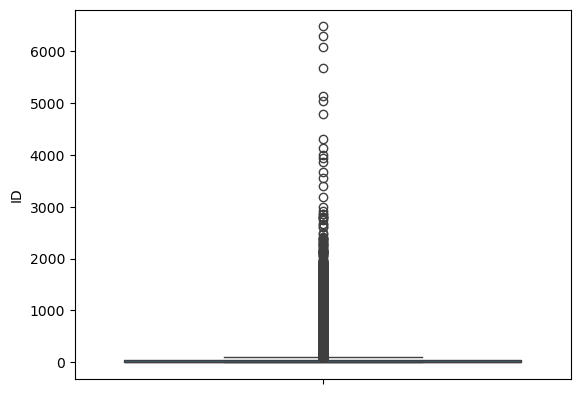

In [15]:
sns.boxplot(groupby_df2['ID'])

In [16]:
groupby_df2.describe()

,rating,ID
count,412815.000000,412815.000000
mean,7.895585,45.940048
std,1.234510,108.486116
min,1.000000,1.000000
25%,7.133333,2.000000
50%,7.785714,12.000000
75%,8.666667,44.000000
max,10.000000,6471.000000


In [12]:
groupby_df2['ID'].mean()

45.94004820561268

<div style="background-color: #ffd3a0; width: 200px; padding: 10px; border-radius: 5px; width: 98.8%">
    <h1 style="color: #5a3731; margin: 0;">Exploratory Data Analysis</h1>
</div>

<div style="background-color: #ffd3a0; width: 200px; padding: 10px; border-radius: 5px; width: 98.8%">
    <h1 style="color: #5a3731; margin: 0;">References</h1>
</div>

Van Elteren, J. (2022). *BoardGameGeek Reviews.* https://www.kaggle.com/datasets/jvanelteren/boardgamegeek-reviews/data